In [4]:
!pip install opencv-python numpy matplotlib

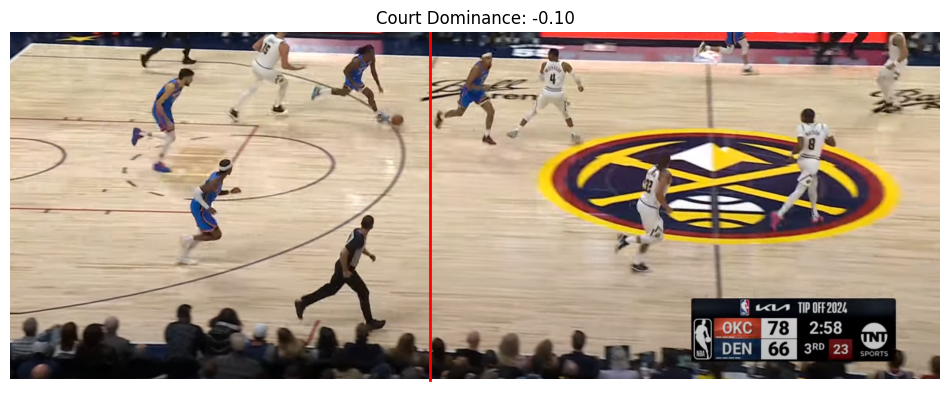

Court Dominance: -0.10


In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_path = '/data/image.png'


def detect_court_dominance(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}. Check the file path and permissions.")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges for court detection
    lower_court = np.array([0, 0, 100])
    upper_court = np.array([180, 100, 255])

    # Create mask for court area
    court_mask = cv2.inRange(hsv_image, lower_court, upper_court)
    kernel = np.ones((5,5), np.uint8)
    court_mask = cv2.morphologyEx(court_mask, cv2.MORPH_CLOSE, kernel)
    court_mask = cv2.morphologyEx(court_mask, cv2.MORPH_OPEN, kernel)

    # Find contours of the court
    contours, _ = cv2.findContours(court_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_court = image_rgb[y:y+h, x:x+w]
        image_enhanced = cv2.convertScaleAbs(cropped_court, alpha=1.2, beta=30)
        hsv_court = cv2.cvtColor(image_enhanced, cv2.COLOR_RGB2HSV)

        # Define color ranges for player detection
        lower_player = np.array([0, 50, 50])
        upper_player = np.array([180, 255, 255])

        # Create mask for players
        player_mask = cv2.inRange(hsv_court, lower_player, upper_player)
        player_mask = cv2.morphologyEx(player_mask, cv2.MORPH_OPEN, kernel)
        player_mask = cv2.morphologyEx(player_mask, cv2.MORPH_CLOSE, kernel)

        # Find contours of players
        player_contours, _ = cv2.findContours(player_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        player_positions = []
        for contour in player_contours:
            if cv2.contourArea(contour) > 200:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    player_positions.append(cX)

        if player_positions:
            average_x_position = np.mean(player_positions)
            court_width = cropped_court.shape[1]
            court_dominance = (2 * average_x_position / court_width) - 1
            plt.figure(figsize=(12, 6))
            plt.imshow(cropped_court)
            plt.plot([average_x_position, average_x_position], [0, cropped_court.shape[0]], 'r-', linewidth=2)
            plt.title(f"Court Dominance: {court_dominance:.2f}")
            plt.axis('off')
            plt.show()

            return court_dominance
        else:
            print("No players detected.")
            return None
    else:
        print("Court area not detected. Adjust the HSV range.")
        return None

dominance = detect_court_dominance(image_path)
if dominance is not None:
    print(f"Court Dominance: {dominance:.2f}")